In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from plot_func.gen_distribution_single_plots import analyze_phases
from plot_func.gen_distribution_subplot import analyze_single_type    # plot_combined_results
from plot_func.gen_distribution_merged_plot import plot_merged_results


In [2]:
def get_output_dir(filename, start_time, end_time):
    """Create and return output directory path based on filename and time range"""
    # filename = os.path.splitext(os.path.basename(bvh_file))[0]
    dir_name = f"{filename}_{start_time:.1f}_{end_time:.1f}"
    output_dir = os.path.join("output_static_plot", dir_name)
    os.makedirs(output_dir, exist_ok=True)
    return output_dir



In [96]:
#   BKO_E1_D1_02_Maraka   BKO_E1_D1_01_Suku
#    BKO_E1_D1_06_Manjanin     BKO_E1_D2_05_Wasulunka

file_name = "BKO_E1_D1_06_Manjanin"       
cycles_csv_path = f"data/virtual_cycles/{file_name}_C.csv"
onsets_csv_path = f"data/drum_onsets/{file_name}.csv"


manjanin = [0.03125, 0.10625, 0.2, 0.28125, 0.35625, 0.45, 0.53125, 0.60625, 0.7, 0.7775, 0.85, 0.9475]
suku =      [0.03375, 0.11125, 0.2025, 0.28375, 0.36125, 0.4525, 0.53375, 0.61125, 0.7025, 0.78375, 0.86125, 0.9525]
maraka =    [0.0425, 0.12375, 0.20625, 0.2925, 0.37375, 0.45625, 0.5425, 0.61, 0.6925, 0.7925, 0.87375, 0.95625]
wasulunka = [0.0425, 0.12625, 0.20875, 0.29, 0.37375, 0.4575, 0.54125, 0.62625, 0.70875, 0.79125, 0.87375, 0.9575]

# manjanin   = [12.5, 42.5, 80,   112.5, 142.5, 180,  212.5, 242.5, 280, 311,   340,   379]
# suku       = [13.5, 44.5, 81,   113.5, 144.5, 181,  213.5, 244.5, 281, 313.5, 344.5, 381]
# maraka     = [17,   49.5, 82.5, 117,   149.5, 182.5,217,   244,   277, 317,   349.5, 382.5]
# wasulunka  = [17,   50.5, 83.5, 116,   149.5, 183,  216.5, 250.5, 283.5,316.5, 349.5, 383]


piece = file_name.split("_")[-1].lower()
boundary_lines = {"manjanin": manjanin, "suku": suku, "maraka": maraka, "wasulunka": wasulunka}

### Individual plots

In [ ]:

# Set figure size (width, height) 
figsize1 = (10, 3)  
dpi1 = 200         

# Create save directory if it doesn't exist
# static_save_dir = "output_static_plot"
os.makedirs(static_save_dir, exist_ok=True)

# Process all onset types
onset_types = ["Dun", "J1", "J2"]
for onset_type in onset_types:
    # Create save path for this onset type
    save_path = os.path.join(static_save_dir, f"{file_name}_{onset_type}_{W_start}_{W_end}.png")
    
    # Analyze phases and save plot
    analyze_phases(
        cycles_csv_path, onsets_csv_path, onset_type, W_start, W_end,
        save_path=save_path, figsize=figsize1, dpi=dpi1
    )
    
    print(f"Saved plot for {onset_type} to {save_path}")

### Combined Subplot No Color

In [40]:
# ### V1
def plot_combined(file_name, cycles_csv_path, onsets_csv_path, W_start=None, W_end=None, figsize=(10, 8), dpi=100, use_window=True):
    """Create a combined plot showing phase analysis for Dun, J1, and J2.
    
    Args:
        file_name: Base name of the file to analyze
        cycles_csv_path: Path to cycles CSV file
        onsets_csv_path: Path to onsets CSV file
        W_start: Start of analysis window (optional if use_window=False)
        W_end: End of analysis window (optional if use_window=False)
        figsize: Tuple of (width, height) in inches
        dpi: Dots per inch for the figure
        use_window: Whether to filter by time window (True) or use all data (False)
    """
    # Create figure with three subplots sharing x-axis
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=figsize, dpi=dpi, sharex=True)
    axes = [ax1, ax2, ax3]
    onset_types = ['Dun', 'J1', 'J2']
    colors = ['blue', 'green', 'red']
    
    # Process each onset type
    for ax, onset_type, color in zip(axes, onset_types, colors):
        # Get phase analysis results
        phases, window_positions, kde_xx, kde_h = analyze_single_type(
            cycles_csv_path, onsets_csv_path, onset_type, W_start, W_end, use_window=use_window
        )
        
        if phases is not None:
            # Plot scatter points (above zero)
            ax.scatter(phases, window_positions, alpha=0.5, color=color, s=5)
            
            # Scale KDE to be between -0.5 and 0, starting from bottom
            kde_scaled = -0.5 + (0.5 * kde_h / np.max(kde_h))
            ax.fill_between(kde_xx, -0.5, kde_scaled, alpha=0.3, color=color)
            
            # Set y-axis limits and ticks
            ax.set_ylim(-0.55, 1.0)
            yticks = np.arange(0, 1.1, 0.2)
            ax.set_yticks(yticks)
            
            # Add grid
            ax.grid(True, alpha=0.3)
            
            # Add onset type label
            ax.set_ylabel(f'{onset_type}\nRelative Position')
            for x in boundary_lines[piece]:
                ax.vlines(x, -0.55, 1.0, color='black', linestyle='--', alpha=0.5)
    
    
    # Set common x-label and title
    axes[-1].set_xlabel('Normalized metric cycle')
    if use_window:
        fig.suptitle(f'File: {file_name} | Window: {W_start:.1f}s - {W_end:.1f}s')
    else:
        fig.suptitle(f'File: {file_name} | Full Recording')
    
    plt.tight_layout()
    return fig, axes

### Colorized by boundary

In [94]:

def plot_combined(file_name,
                          cycles_csv_path,
                          onsets_csv_path,
                          boundary_marker,
                          W_start=None,
                          W_end=None,
                          figsize=(10, 8),
                          dpi=100,
                          use_window=True,
                          ):
    
    """Plot Dun, J1, J2, coloring each scatter segment
    between boundary_lines[piece] identically across panels."""


    # build bin edges once
    edges = [0.0] + boundary_marker + [1.0]
    n_bins = len(edges) - 1
    base_colors = plt.get_cmap('tab10').colors

    step = 3  # 3 is co-prime to 10
    segment_colors = [
        base_colors[(i * step) % len(base_colors)]
        for i in range(n_bins)
    ]

    xtick = [0, 33, 67, 100, 133, 167, 200, 233, 267, 300, 333, 367, 400]
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1,
                                        figsize=figsize,
                                        dpi=dpi,
                                        sharex=True)
    axes = [ax1, ax2, ax3]
    onset_types = ['Dun', 'J1', 'J2']

    for ax, onset_type in zip(axes, onset_types):
        phases, window_positions, kde_xx, kde_h = analyze_single_type(
            cycles_csv_path,
            onsets_csv_path,
            onset_type,
            W_start,
            W_end,
            use_window=use_window
        )
        if phases is None:
            continue

        # assign each phase into a bin
        bin_idx = np.digitize(phases, edges) - 1
        bin_idx = np.clip(bin_idx, 0, n_bins-1)     # new
        # scatter each bin in its color
        for seg in range(n_bins):
            mask = bin_idx == seg
            if not mask.any():
                continue
            ax.scatter(
                phases[mask] * 400,
                window_positions[mask],
                s=5,
                alpha=0.6,
                color=segment_colors[seg],
            )

        # draw KDE (stretched 0–1→0–400)
        kde_scaled = -0.5 + 0.5 * (kde_h / np.max(kde_h))
        ax.fill_between(
            kde_xx * 400,
            -0.5,
            kde_scaled,
            alpha=0.3,
            color='gray',
        )

        # draw the boundaries
        for x0 in boundary_marker:
            x_pos = x0 * 400
            ax.vlines(
                x_pos, -0.55, 1.0,
                color='black', linestyle='--', alpha=0.5
            )
            
            ax.text(
                x_pos, 1.02,
                f"{x_pos:.2f}",
                rotation=90,
                ha='center',
                va='bottom',
                transform=ax.get_xaxis_transform(),  # x in data, y in axis‐fraction
                clip_on=False,                       # allow text outside the axes box
                fontsize=8,
                color='black',
                )

        # styling
        ax.set_ylim(-0.55, 1.0)
        ax.set_xticks(xtick)
        ax.set_yticks(np.arange(0, 1.1, 0.2))
        ax.grid(True, alpha=0.3)
        ax.set_ylabel(f'{onset_type}\nRelative Position')
        ax.set_xlim(-25, 400)

    # final labels
    axes[-1].set_xlabel('Metric cycle (0 – 400)')
    title = f'File: {file_name}'
    title += f' | Window: {W_start:.1f}s–{W_end:.1f}s' if use_window else ' | Full Recording'
    fig.suptitle(title)

    plt.tight_layout()
    return fig, axes


## Stacked Plot

In [132]:
def plot_merged_stacked(file_name,
                        cycles_csv_path,
                        onsets_csv_path,
                        boundary_marker,
                        W_start=None,
                        W_end=None,
                        figsize=(10, 12),
                        dpi=100,
                        use_window=True,
                        ):
    """Create a single plot showing merged analysis for Dun, J1, and J2
    with stacked, segment-colored scatter and combined KDE."""
    
    # 1) prepare bins & colors from boundary_marker (normalized 0–1)
    edges = [0.0] + boundary_marker + [1.0]
    n_bins = len(edges) - 1
    base_colors = plt.get_cmap('tab10').colors
    step = 3  # co-prime to 10 so adjacent segments differ
    segment_colors = [base_colors[(i*step) % len(base_colors)]
                      for i in range(n_bins)]
    
    # 2) define major xticks (0–400 in ~12 segments)
    xtick = [0, 33, 67, 100, 133, 167, 200, 233, 267, 300, 333, 367, 400]

    # 3) set up single merged axes
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    onset_types = ['Dun', 'J1', 'J2']
    colors      = ['blue', 'green', 'red']
    # vertical stacking ranges for each type
    vertical_ranges = {
        'Dun': (1, 6),    # y from 1–6
        'J1':  (8, 13),   # y from 8–13
        'J2':  (15, 20),  # y from 15–20
    }

    combined_h = None
    combined_xx = None

    # 4) loop onset types, plot segment-colored scatter
    for onset_type, color in zip(onset_types, colors):
        phases, window_pos, kde_xx, kde_h = analyze_single_type(
            cycles_csv_path, onsets_csv_path,
            onset_type, W_start, W_end,
            use_window=use_window
        )
        if phases is None:
            continue

        # stack y
        y0, y1 = vertical_ranges[onset_type]
        y_scaled = y0 + (window_pos * (y1 - y0))

        # bin & clamp
        bin_idx = np.digitize(phases, edges) - 1
        bin_idx = np.clip(bin_idx, 0, n_bins-1)

        # scatter each segment
        for seg in range(n_bins):
            mask = bin_idx == seg
            if not np.any(mask):
                continue
            ax.scatter(phases[mask] * 400,
                       y_scaled[mask],
                       s=5, alpha=0.6,
                       color=segment_colors[seg])

        # accumulate KDE
        if combined_h is None:
            combined_h = kde_h.copy()
            combined_xx = kde_xx.copy()
        else:
            combined_h += kde_h

    # 5) draw combined KDE at bottom (-5 to 0)
    if combined_h is not None:
        # normalize to 0–1
        combined_h = combined_h / np.max(combined_h)
        kde_scaled = -5 + (5 * combined_h)
        ax.fill_between(combined_xx * 400,
                        -5, kde_scaled,
                        alpha=0.3, color='purple',
                        label='Combined KDE')

    # 6) draw vertical boundary lines + labels
    for x0 in boundary_marker:
        x_pos = x0 * 400
        ax.vlines(x_pos, -5.5, 20.5,
                  color='black', linestyle='--', alpha=0.5)
        ax.text(x_pos, 1.02,         # y=1.02 in axis-fraction
                f"{x_pos:.0f}",
                rotation=90,
                ha='center', va='bottom',
                transform=ax.get_xaxis_transform(),
                clip_on=False,
                fontsize=8,
                color='black')

    # 7) styling & axes
    ax.set_xlim(0, 400)
    ax.set_xticks(xtick)
    ax.set_xlabel('Metric cycle (0-400)')
    
    ax.set_ylim(-5.5, 20.5)
    ax.set_yticks([3, 10, 17])
    ax.set_yticklabels(['Dun', 'J1', 'J2'])
    
    ax.set_ylabel('Stacked Relative Positions')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-33, 400)

    # 8) title & legend
    title = f'File: {file_name}'
    title += f' | Window: {W_start:.1f}s - {W_end:.1f}s' if use_window else ' | Full Recording'
    ax.set_title(title, pad = 40)

    # ax.legend(loc='upper right', framealpha=0.7, fontsize='small')
    
    plt.tight_layout()
    plt.show()

    return fig, ax


## Plot for a time segment

In [61]:
# W_start = 0    
# W_end = 200
# static_save_dir = get_output_dir(file_name, W_start, W_end)

# figsize2 = (10, 9)  
# dpi2 = 200
# fig, _ = plot_combined_results(file_name, cycles_csv_path, onsets_csv_path, W_start, W_end, figsize=figsize2, dpi=dpi2)       


# save_path_window = os.path.join(static_save_dir, f"{file_name}_{W_start}_{W_end}__subplot.png")
# fig.savefig(save_path_window, bbox_inches='tight', dpi=dpi2)
# plt.close(fig)  # Close the figure to free memory 

## Plot full duration

Dun - Total onsets: 2879
J1 - Total onsets: 2879
J2 - Total onsets: 2879


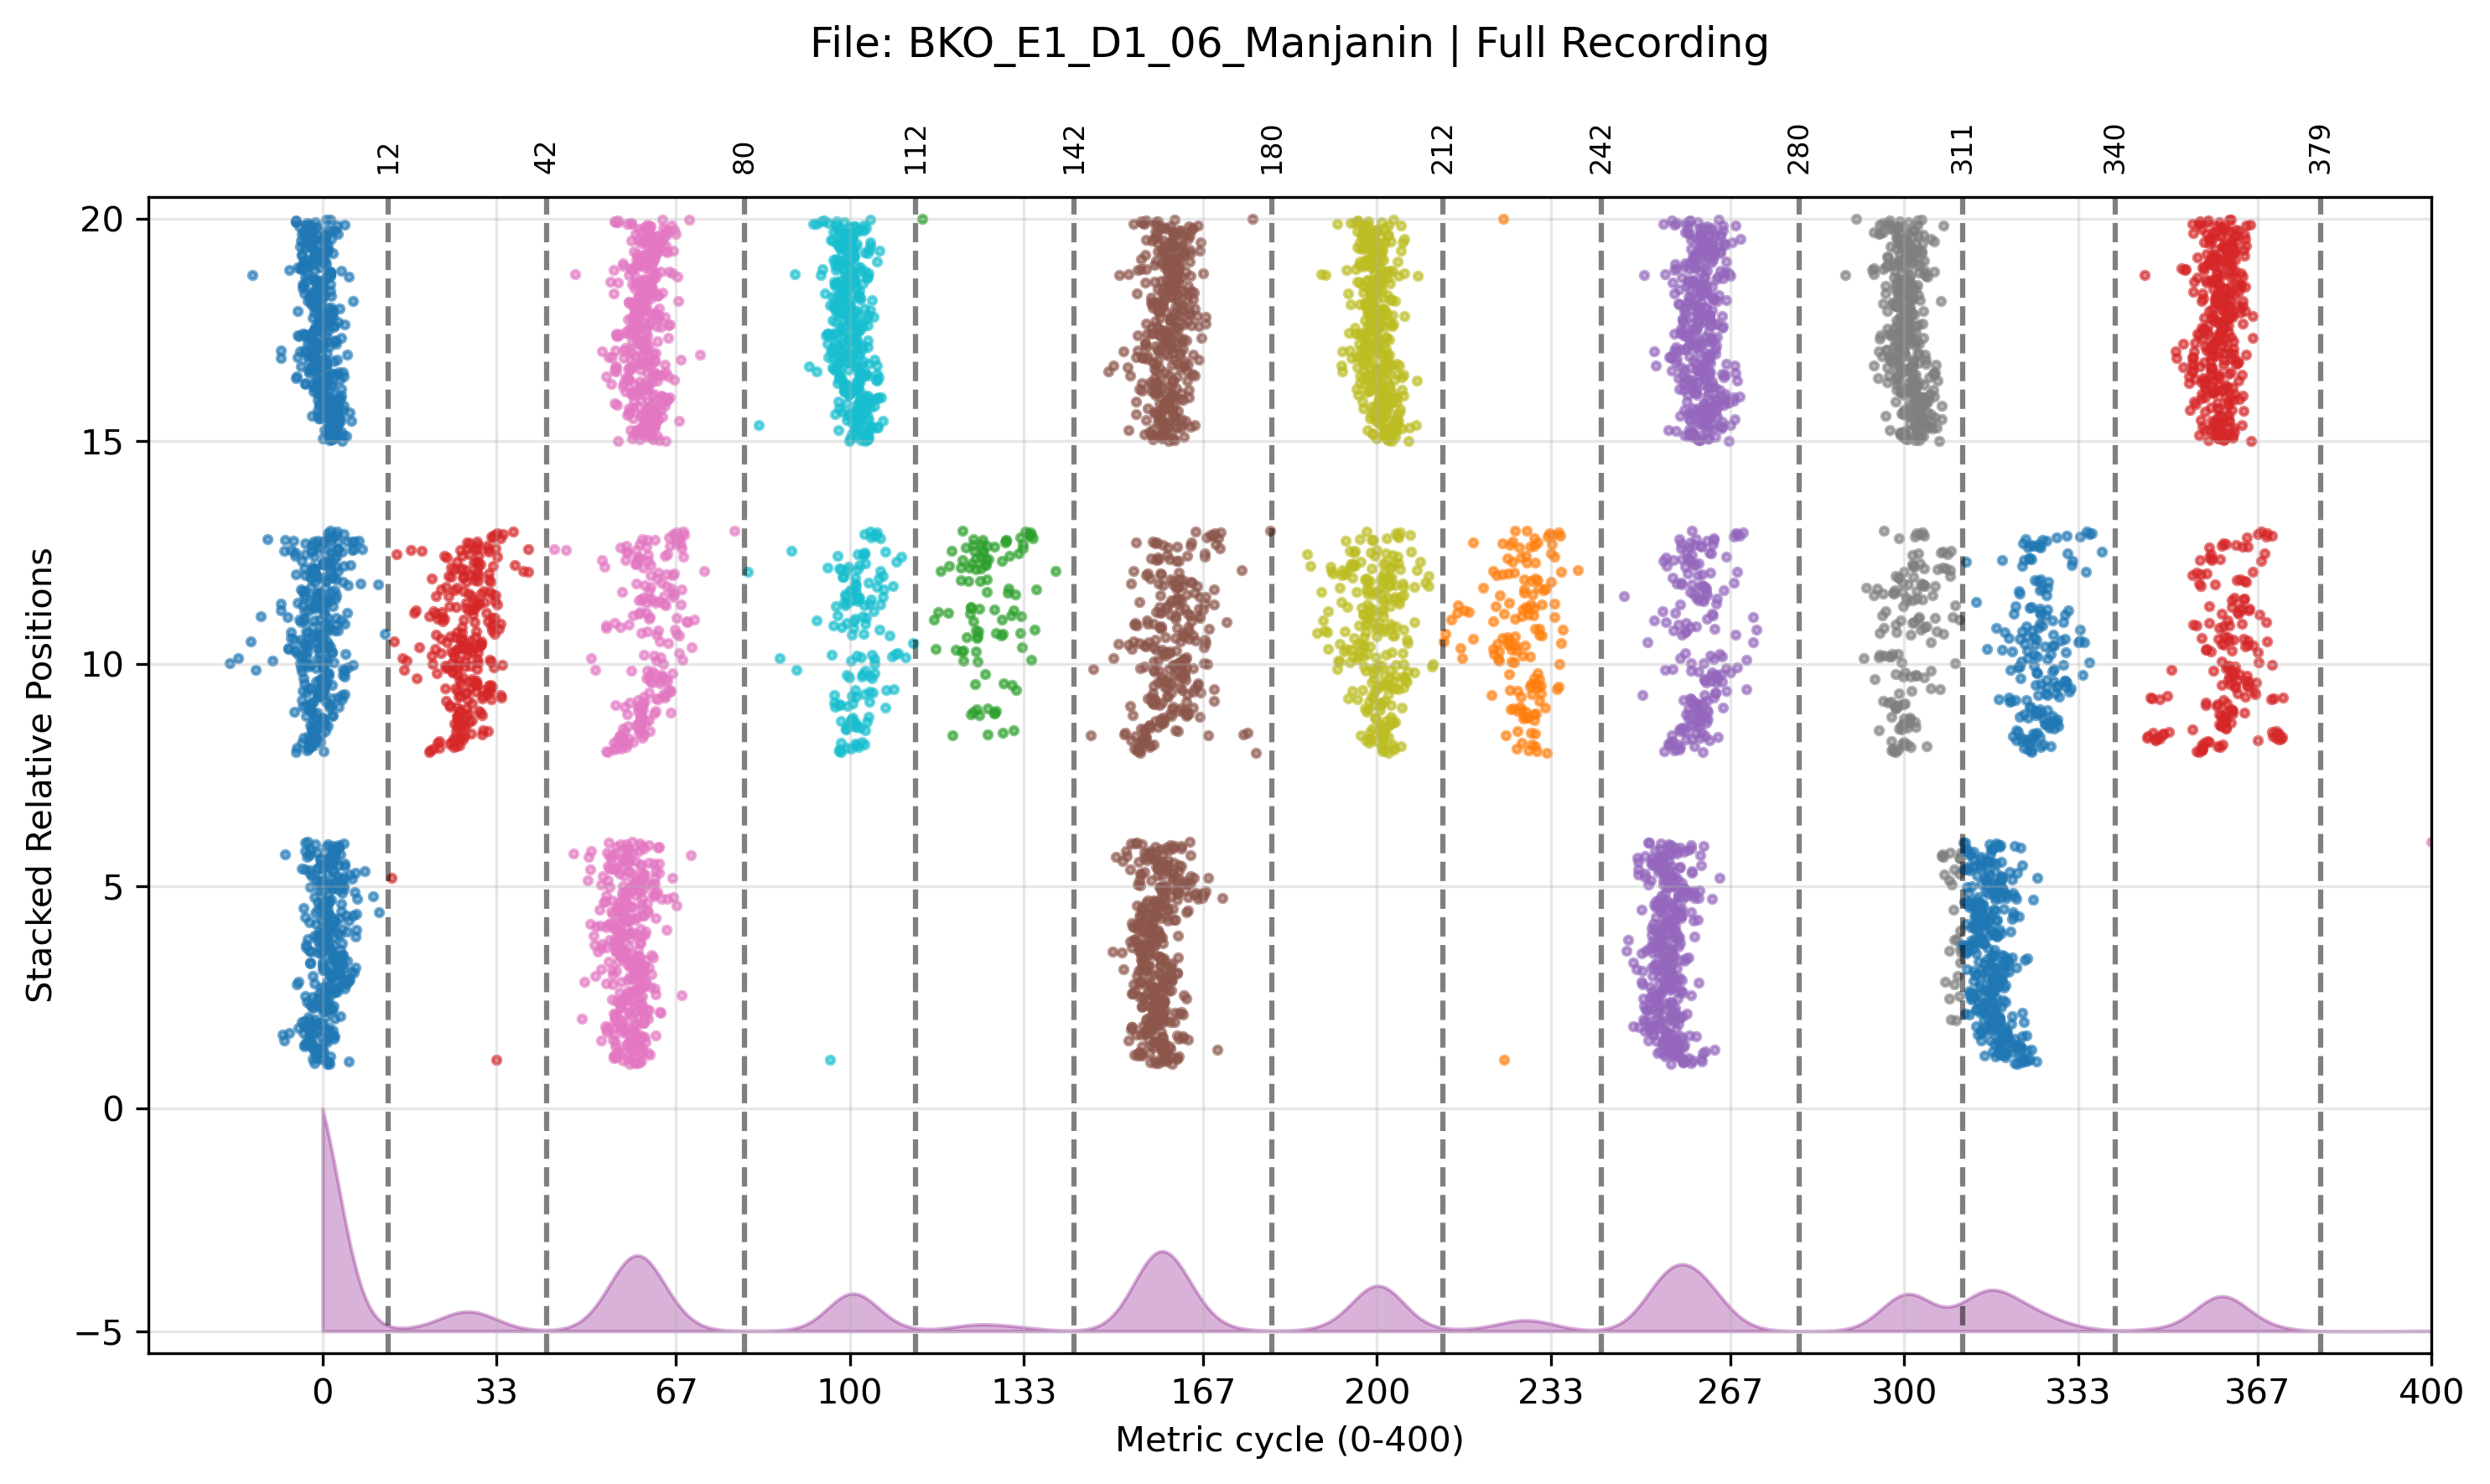

In [133]:
# file_name = "BKO_E1_D1_02_Maraka"
# cycles_csv_path = f"data/virtual_cycles/{file_name}_C.csv"
# onsets_csv_path = f"data/drum_onsets/{file_name}.csv"
# W_start = 70    
# W_end = 75

figsize2 = (10, 6)
dpi2 = 300
     
# fig, _ = plot_combined(file_name, cycles_csv_path, onsets_csv_path, boundary_lines[piece],
#                        figsize=figsize2, dpi=dpi2, use_window=False,
                    #    )
fig, _ = plot_merged_stacked(file_name,
                        cycles_csv_path,
                        onsets_csv_path,
                        boundary_lines[piece],
                        W_start=None,
                        W_end=None,
                        figsize= figsize2,
                        dpi=300,
                        use_window=False,
                        )
# save_path_window = os.path.join(static_save_dir, f"{file_name}_{W_start}_{W_end}__subplot.png")

save_path_full = f"output_static_plot\\{file_name}_full_duration_subplot.png"
# fig.savefig(save_path_full, bbox_inches='tight', dpi=dpi2)
# plt.close(fig)  # Close the figure to free memory 

### Merged Plot

In [ ]:
# file_name = "BKO_E1_D1_02_Maraka"
# cycles_csv_path = f"data/virtual_cycles/{file_name}_C.csv"
# onsets_csv_path = f"data/drum_onsets/{file_name}.csv"
# W_start = 70    
# W_end = 75

figsize3 = (10, 3)  
dpi3 = 200    

fig, _ = plot_merged_results(file_name, W_start, W_end, cycles_csv_path, onsets_csv_path, figsize=figsize3, dpi=dpi3)
save_path = os.path.join(static_save_dir, f"{file_name}_{W_start}_{W_end}__merged.png")
fig.savefig(save_path, bbox_inches='tight', dpi=dpi3)
plt.close(fig)  # Close the figure to free memory 